# Regression

In [1]:
import geopandas as gpd

blocks_gdf = gpd.read_parquet('./../data/blocks.parquet')

In [2]:
from blocksnet.relations import generate_adjacency_graph

adjacency_graph = generate_adjacency_graph(blocks_gdf, 10)

2025-04-06 17:48:26.175 | INFO     | blocksnet.relations.adjacency.core:_generate_adjacency_nodes:10 - Generating nodes
2025-04-06 17:48:26.182 | INFO     | blocksnet.relations.adjacency.core:_generate_adjacency_edges:15 - Generating edges
2025-04-06 17:48:27.552 | SUCCESS  | blocksnet.relations.adjacency.core:generate_adjacency_graph:34 - Adjacency graph successfully generated: 16320 nodes, 16036 edges


## Density

In [3]:
from blocksnet.machine_learning.regression import DensityRegressor

dr = DensityRegressor()

### Train

In [4]:
data = dr.get_train_data(blocks_gdf, adjacency_graph)

2025-04-06 17:35:50.013 | WARNING  | blocksnet.machine_learning.regression.density.schemas:_before_validate:37 - Not valid format. Trying to one hot from land_use column
2025-04-06 17:35:52.611 | INFO     | blocksnet.preprocessing.feature_engineering.core:_calculate_usual_features:34 - Calculating usual features
2025-04-06 17:35:52.849 | INFO     | blocksnet.machine_learning.regression.density.core:_features_from_geometries:32 - Fitting the scaler


In [6]:
losses = dr.train(data, epochs=1_000)

Current loss : 0.00525: 100%|██████████| 1000/1000 [00:12<00:00, 77.77it/s]


### Test

In [7]:
dr.test(data)

0.00555845582857728

### Evaluate

In [4]:
result_df = dr.evaluate(blocks_gdf, adjacency_graph)

2025-04-06 17:48:37.235 | WARNING  | blocksnet.machine_learning.regression.density.schemas:_before_validate:37 - Not valid format. Trying to one hot from land_use column
2025-04-06 17:48:39.870 | INFO     | blocksnet.preprocessing.feature_engineering.core:_calculate_usual_features:34 - Calculating usual features


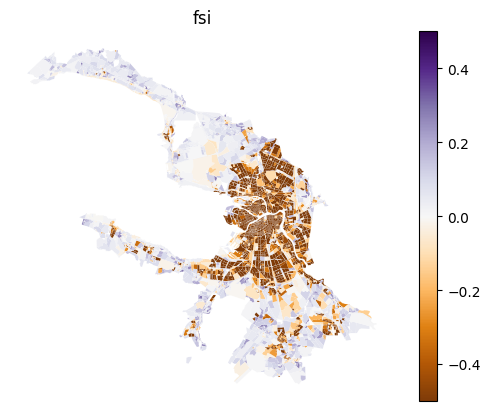

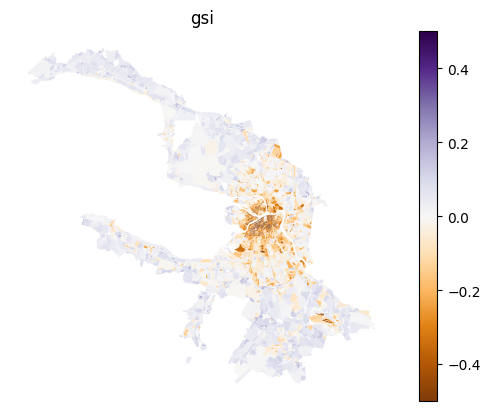

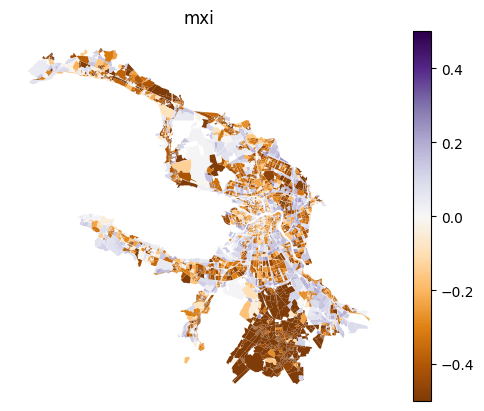

In [5]:
df = result_df.copy()
for column in df.columns:
  df[column] -= blocks_gdf[column]
  ax = blocks_gdf[['geometry']].join(df).plot(column, cmap='PuOr', legend=True, vmin=-0.5, vmax=0.5)
  ax.set_title(column)
  ax.set_axis_off()

## Save model and scaler

In [12]:
dr.save_model('model.pt')
dr.save_scaler('scaler.pkl')